## Setup & Imports

In [5]:
!pip -q install duckdb pyarrow pandas matplotlib

import os
import duckdb as ddb
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True

print("Versions:")
print("  duckdb:", ddb.__version__)
print("  pyarrow:", pa.__version__)
print("  pandas:", pd.__version__)

Versions:
  duckdb: 1.3.2
  pyarrow: 18.1.0
  pandas: 2.2.2


## Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

PARQUET_PATH = "/content/drive/MyDrive/MBTA_Bus_Arrival_Departure_Times/MBTA Bus Arrival Departure Times/merged_output/mbta_arrival_departure_merged_direction.parquet"

OUT_DIR = "/content/drive/MyDrive/mbta/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

assert os.path.exists(PARQUET_PATH), f"File not found: {PARQUET_PATH}"
print("Parquet found ✅:", PARQUET_PATH)
print("Out dir:", OUT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Parquet found ✅: /content/drive/MyDrive/MBTA_Bus_Arrival_Departure_Times/MBTA Bus Arrival Departure Times/merged_output/mbta_arrival_departure_merged_direction.parquet
Out dir: /content/drive/MyDrive/mbta/outputs


## Inspect schema & row-group sizes (zero data read)

In [6]:
import numpy as np
import pyarrow.parquet as pq

pf = pq.ParquetFile(PARQUET_PATH)

print("Parquet file:", PARQUET_PATH)
print("# Row groups:", pf.num_row_groups)

rg_rows = [pf.metadata.row_group(i).num_rows for i in range(pf.num_row_groups)]
total_rows = int(np.sum(rg_rows))
print("Estimated total rows:", total_rows)
print("Row-group size (rows): min/median/max =",
      int(np.min(rg_rows)), int(np.median(rg_rows)), int(np.max(rg_rows)))
print("First 10 row-group sizes:", [int(x) for x in rg_rows[:10]])
arrow_schema = pf.schema.to_arrow_schema()
print("\nColumns:")
for f in arrow_schema:
    print(f"  - {f.name}: {f.type}")

Parquet file: /content/drive/MyDrive/MBTA_Bus_Arrival_Departure_Times/MBTA Bus Arrival Departure Times/merged_output/mbta_arrival_departure_merged_direction.parquet
# Row groups: 242
Estimated total rows: 198706085
Row-group size (rows): min/median/max = 80638 1000000 1000000
First 10 row-group sizes: [1000000, 1000000, 1000000, 1000000, 1000000, 117779, 1000000, 1000000, 1000000, 1000000]

Columns:
  - service_date: string
  - route_id: string
  - stop_id: int64
  - half_trip_id: int64
  - time_point_id: string
  - time_point_order: int64
  - actual: string
  - scheduled: string
  - scheduled_headway: double
  - headway: double
  - point_type: string
  - standard_type: string
  - earliness: double
  - direction: string


## Safe sample + quick visuals (DuckDB limits rows)

In [7]:
import duckdb as ddb
import pandas as pd

con = ddb.connect()

sql_counts = f"""
WITH base AS (
  SELECT point_type, scheduled, actual
  FROM read_parquet('{PARQUET_PATH}')
  LIMIT 2000000
)
SELECT
  lower(trim(coalesce(point_type,''))) AS pt,
  count(*) AS n_rows,
  sum(CASE WHEN scheduled IS NOT NULL THEN 1 ELSE 0 END) AS n_sched,
  sum(CASE WHEN actual    IS NOT NULL THEN 1 ELSE 0 END) AS n_act,
  sum(CASE WHEN scheduled IS NOT NULL AND actual IS NOT NULL THEN 1 ELSE 0 END) AS n_both
FROM base
GROUP BY 1
ORDER BY n_rows DESC;
"""
pt_counts = con.execute(sql_counts).fetchdf()
print(pt_counts)

sql_peek = f"""
SELECT scheduled, actual, point_type
FROM read_parquet('{PARQUET_PATH}')
WHERE scheduled IS NOT NULL AND actual IS NOT NULL
LIMIT 20;
"""
peek = con.execute(sql_peek).fetchdf()
print("\nSample of datetime strings:")
print(peek.head(10))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

           pt   n_rows    n_sched      n_act     n_both
0    midpoint  1440122  1440122.0  1351845.0  1351845.0
1    endpoint   280062   280062.0   253245.0   253245.0
2  startpoint   279816   279816.0   255235.0   255235.0

Sample of datetime strings:
              scheduled                actual  point_type
0  1900-01-01T05:19:00Z  1900-01-01T05:19:34Z    Midpoint
1  1900-01-01T05:22:00Z  1900-01-01T05:23:20Z    Midpoint
2  1900-01-01T05:25:00Z  1900-01-01T05:25:58Z    Midpoint
3  1900-01-01T05:28:00Z  1900-01-01T05:28:26Z    Midpoint
4  1900-01-01T05:30:00Z  1900-01-01T05:29:57Z  Startpoint
5  1900-01-01T05:32:00Z  1900-01-01T05:33:38Z    Midpoint
6  1900-01-01T05:33:00Z  1900-01-01T05:34:00Z    Endpoint
7  1900-01-01T05:33:00Z  1900-01-01T05:35:21Z    Midpoint
8  1900-01-01T05:36:00Z  1900-01-01T05:39:52Z    Midpoint
9  1900-01-01T05:39:00Z  1900-01-01T05:44:39Z    Midpoint


In [10]:
import os, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

OUT_DIR = globals().get("OUT_DIR", "/content/drive/MyDrive/mbta/outputs")
FIG_DIR = os.path.join(OUT_DIR, "figures_sample_4b")
os.makedirs(FIG_DIR, exist_ok=True)

plt.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.dpi": 150,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.frameon": False,
    "axes.axisbelow": True,
    "savefig.bbox": "tight",
})

def savefig(name: str):
    path = os.path.join(FIG_DIR, name)
    plt.savefig(path)
    print("Saved:", path)

def fmt_thousands(x, _):  # 12,345 style
    try: return f"{int(x):,}"
    except: return str(x)

In [16]:
import duckdb as ddb
import pandas as pd

con = ddb.connect()
SAMPLE_ROWS = 1000_000

def fetch_sample(pt_filter: str | None):
    base_sql = f"""
    SELECT
      route_id,
      lower(trim(coalesce(point_type,''))) AS pt,
      service_date,
      scheduled_headway,
      replace(replace(trim(scheduled),'T',' '),'Z','') AS scheduled_s,
      replace(replace(trim(actual),'T',' '),'Z','')    AS actual_s
    FROM read_parquet('{PARQUET_PATH}')
    WHERE scheduled IS NOT NULL AND actual IS NOT NULL
    """
    if pt_filter:
        base_sql += f"  AND lower(trim(coalesce(point_type,''))) = '{pt_filter}'\n"
    base_sql += f"LIMIT {SAMPLE_ROWS};"
    return con.execute(base_sql).fetchdf()

sample = fetch_sample("endpoint"); used_pt = "endpoint"
if sample.empty:
    sample = fetch_sample("midpoint"); used_pt = "midpoint"
if sample.empty:
    sample = fetch_sample(None);      used_pt = "any"

print(f"Sample shape: {sample.shape}  (point_type used: {used_pt})")
display(sample.head(10))

sample["scheduled_ts"] = pd.to_datetime(sample["scheduled_s"], errors="coerce", utc=True).dt.tz_localize(None)
sample["actual_ts"]    = pd.to_datetime(sample["actual_s"],    errors="coerce", utc=True).dt.tz_localize(None)
sample = sample.dropna(subset=["scheduled_ts","actual_ts"]).copy()
sample["delay_min"] = (sample["actual_ts"] - sample["scheduled_ts"]).dt.total_seconds() / 60.0
sample["delay_min_clean"] = sample["delay_min"].clip(-30, 120)

print("After datetime parse:", sample.shape)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Sample shape: (1000000, 6)  (point_type used: endpoint)


,route_id,pt,service_date,scheduled_headway,scheduled_s,actual_s
0,01,endpoint,2018-08-01T00:00:00Z,NaN,1900-01-01 05:33:00,1900-01-01 05:34:00
1,01,endpoint,2018-08-01T00:00:00Z,1200.0,1900-01-01 05:53:00,1900-01-01 06:00:30
2,01,endpoint,2018-08-01T00:00:00Z,1200.0,1900-01-01 06:13:00,1900-01-01 06:16:54
3,01,endpoint,2018-08-01T00:00:00Z,960.0,1900-01-01 06:29:00,1900-01-01 06:35:17
4,01,endpoint,2018-08-01T00:00:00Z,1260.0,1900-01-01 06:50:00,1900-01-01 06:56:18
5,01,endpoint,2018-08-01T00:00:00Z,960.0,1900-01-01 07:06:00,1900-01-01 07:15:14
6,01,endpoint,2018-08-01T00:00:00Z,720.0,1900-01-01 07:18:00,1900-01-01 07:16:27
7,01,endpoint,2018-08-01T00:00:00Z,600.0,1900-01-01 07:28:00,1900-01-01 07:34:46
8,01,endpoint,2018-08-01T00:00:00Z,600.0,1900-01-01 07:38:00,1900-01-01 07:39:07
9,01,endpoint,2018-08-01T00:00:00Z,780.0,1900-01-01 07:51:00,1900-01-01 07:54:37


After datetime parse: (1000000, 10)


Saved: /content/drive/MyDrive/mbta/outputs/figures_sample_4b/sample_top20_routes.png


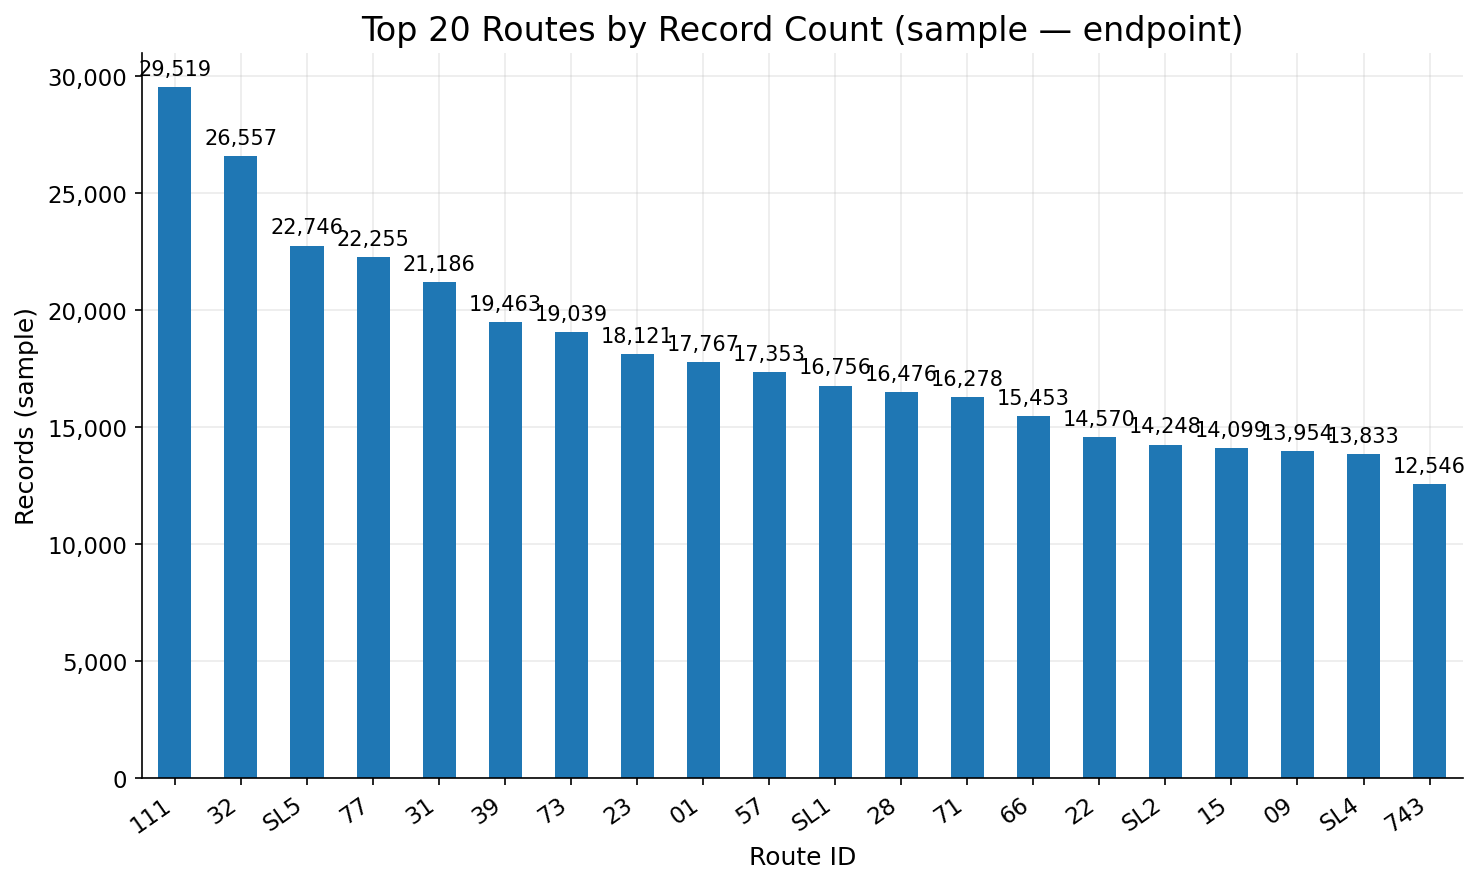

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

cnt = sample["route_id"].astype(str).value_counts().head(20)
plt.figure()
ax = cnt.plot(kind="bar")
ax.yaxis.set_major_formatter(FuncFormatter(fmt_thousands))
plt.xticks(rotation=35, ha="right")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}",
                (p.get_x()+p.get_width()/2, p.get_height()),
                xytext=(0, 4), textcoords="offset points", ha="center", va="bottom")
plt.title(f"Top 20 Routes by Record Count (sample — {used_pt})")
plt.xlabel("Route ID"); plt.ylabel("Records (sample)")
plt.tight_layout(); savefig("sample_top20_routes.png"); plt.show()

Saved: /content/drive/MyDrive/mbta/outputs/figures_sample_4b/sample_headway_delay_side_by_side.png


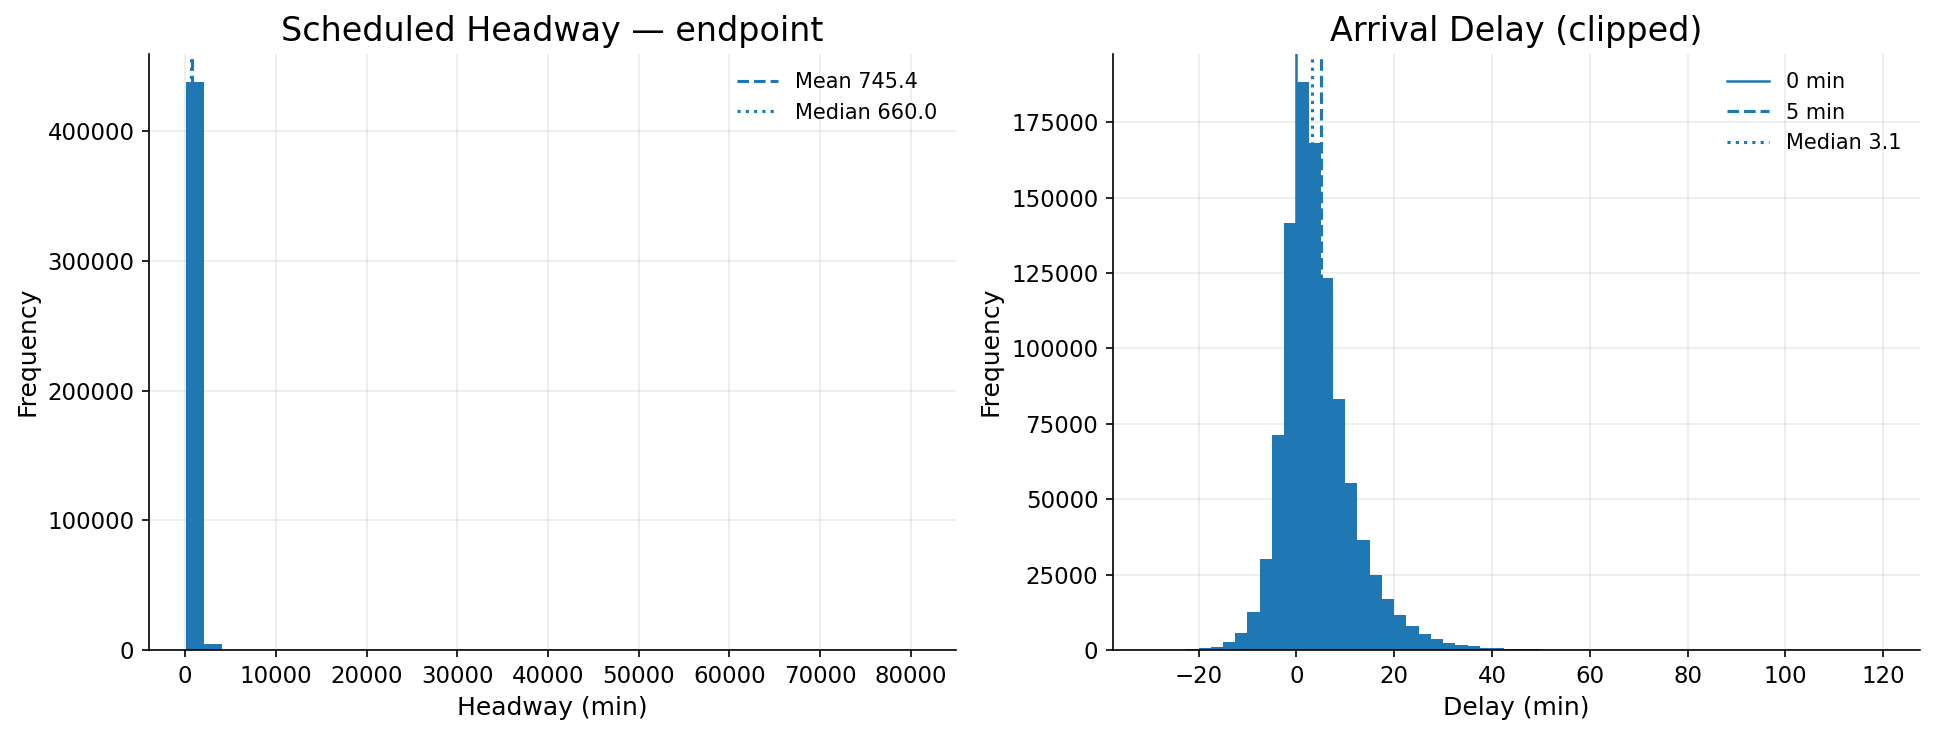

In [21]:
import numpy as np, matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(13,5), sharey=False)
if "scheduled_headway" in sample.columns:
    hw = pd.to_numeric(sample["scheduled_headway"], errors="coerce").dropna()
    if not hw.empty:
        axes[0].hist(hw, bins=40)
        axes[0].axvline(hw.mean(), linestyle="--", linewidth=1.5, label=f"Mean {hw.mean():.1f}")
        axes[0].axvline(hw.median(), linestyle=":", linewidth=1.5, label=f"Median {hw.median():.1f}")
        axes[0].set_title(f"Scheduled Headway — {used_pt}")
        axes[0].set_xlabel("Headway (min)"); axes[0].set_ylabel("Frequency")
        axes[0].legend()
# Delay
delays = sample["delay_min_clean"].dropna()
axes[1].hist(delays, bins=60)
axes[1].axvline(0,  linestyle="-",  linewidth=1.2, label="0 min")
axes[1].axvline(5,  linestyle="--", linewidth=1.5, label="5 min")
axes[1].axvline(delays.median(), linestyle=":", linewidth=1.5, label=f"Median {delays.median():.1f}")
axes[1].set_title("Arrival Delay (clipped)")
axes[1].set_xlabel("Delay (min)"); axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout(); savefig("sample_headway_delay_side_by_side.png"); plt.show()

In [30]:
# === Cell 5: Route-level metrics from full Parquet (Endpoint preference) ===
import os, duckdb as ddb, pandas as pd

con = ddb.connect()

MIN_OBS = 300  # require at least this many Endpoint records per route

OUT_PARQUET_ROUTES = os.path.join(OUT_DIR, "route_metrics_endpoint.parquet")
OUT_CSV_ROUTES     = os.path.join(OUT_DIR, "route_metrics_endpoint.csv")

sql_routes = f"""
WITH base AS (
  SELECT
    route_id,
    lower(trim(coalesce(point_type,''))) AS pt,
    scheduled_headway,
    headway,
    -- normalize ISO -> space and drop trailing Z (robust parse)
    replace(replace(trim(scheduled),'T',' '),'Z','') AS scheduled_s,
    replace(replace(trim(actual),'T',' '),'Z','')    AS actual_s
  FROM read_parquet('{PARQUET_PATH}')
),
endpoint AS (
  SELECT
    route_id,
    scheduled_headway,
    headway,
    CAST(scheduled_s AS TIMESTAMP) AS scheduled_ts,
    CAST(actual_s    AS TIMESTAMP) AS actual_ts
  FROM base
  WHERE pt = 'endpoint'
    AND scheduled_s IS NOT NULL AND actual_s IS NOT NULL
),
clean AS (
  SELECT
    route_id,
    scheduled_headway,
    headway,
    DATE_DIFF('second', scheduled_ts, actual_ts) / 60.0 AS delay_min
  FROM endpoint
  WHERE scheduled_ts IS NOT NULL AND actual_ts IS NOT NULL
    AND DATE_DIFF('second', scheduled_ts, actual_ts) / 60.0 BETWEEN -30 AND 120
),
agg AS (
  SELECT
    route_id,
    COUNT(*)                                   AS num_obs,
    AVG(delay_min)                             AS avg_delay_min,
    MEDIAN(delay_min)                          AS med_delay_min,
    STDDEV_SAMP(delay_min)                     AS std_delay_min,
    APPROX_QUANTILE(delay_min, 0.90)           AS p90_delay_min,
    AVG(CASE WHEN delay_min > 5 THEN 1 ELSE 0 END)::DOUBLE    AS late_fraction,
    AVG(scheduled_headway)::DOUBLE             AS avg_headway_min_sched,
    AVG(headway)::DOUBLE                       AS avg_headway_min_obs,
    AVG(headway - scheduled_headway)::DOUBLE   AS avg_headway_gap_min,
    AVG(CASE WHEN scheduled_headway > 0 AND headway < 0.5 * scheduled_headway
             THEN 1 ELSE 0 END)::DOUBLE        AS bunching_rate,
    AVG(CASE WHEN scheduled_headway > 0 AND headway > 1.5 * scheduled_headway
             THEN 1 ELSE 0 END)::DOUBLE        AS overspaced_rate
  FROM clean
  GROUP BY route_id
)
SELECT *
FROM agg
WHERE num_obs >= {MIN_OBS}
ORDER BY avg_delay_min DESC;
"""

routes = con.execute(sql_routes).fetchdf()
print("routes shape:", routes.shape)
display(routes.head(10))

# Save for downstream visuals & clustering
routes.to_parquet(OUT_PARQUET_ROUTES)
routes.to_csv(OUT_CSV_ROUTES, index=False)
print("Saved:", OUT_PARQUET_ROUTES)
print("Saved:", OUT_CSV_ROUTES)

# === Cell 6: K-Means++ clustering on full-data route metrics, with visuals ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from matplotlib.ticker import FuncFormatter

# -------------- theming --------------
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.dpi": 120,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.frameon": False,
    "axes.axisbelow": True,
    "font.size": 12,
})
def fmt_thousands(x, _pos=None): return f"{int(x):,}"

# -------------- choose features robustly --------------
routes_df = routes.copy()

candidate_feats = [
    "avg_delay_min", "med_delay_min", "std_delay_min", "p90_delay_min",
    "late_fraction",
    "avg_headway_min_sched", "avg_headway_min_obs", "avg_headway_gap_min",
    "bunching_rate", "overspaced_rate"
]

# keep features with at least 60% non-null
valid_feats = [c for c in candidate_feats if routes_df[c].notna().mean() >= 0.60]
if len(valid_feats) < 4:
    # fallback to delay-centric core if headway fields are sparse
    valid_feats = ["avg_delay_min", "med_delay_min", "std_delay_min", "p90_delay_min", "late_fraction"]

print("Using features:", valid_feats)

X = routes_df[valid_feats].copy()

# impute remaining NaNs with column median
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median(numeric_only=True))

# standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------- pick K via silhouette sweep --------------
Ks = range(2, 9)
sil_scores = []
inertias = []
for k in Ks:
    km = KMeans(n_clusters=k, init="k-means++", n_init="auto", random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

best_k = Ks[int(np.argmax(sil_scores))]
print("Silhouette by k:", {k: round(s, 3) for k, s in zip(Ks, sil_scores)})
print("Selected k =", best_k)

# final KMeans
kmeans = KMeans(n_clusters=best_k, init="k-means++", n_init="auto", random_state=42)
routes_df["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

# quality metrics
sil = silhouette_score(X_scaled, routes_df["cluster_kmeans"])
dbi = davies_bouldin_score(X_scaled, routes_df["cluster_kmeans"])
chi = calinski_harabasz_score(X_scaled, routes_df["cluster_kmeans"])
print(f"KMeans(k={best_k}) → silhouette={sil:.3f}, DBI={dbi:.3f}, CHI={chi:.1f}")

# -------------- save results --------------
OUT_ROUTES_CLU_PQ = os.path.join(OUT_DIR, "route_metrics_with_clusters.parquet")
OUT_ROUTES_CLU_CSV = os.path.join(OUT_DIR, "route_metrics_with_clusters.csv")
routes_df.to_parquet(OUT_ROUTES_CLU_PQ)
routes_df.to_csv(OUT_ROUTES_CLU_CSV, index=False)
print("Saved:", OUT_ROUTES_CLU_PQ)
print("Saved:", OUT_ROUTES_CLU_CSV)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

routes shape: (181, 12)


,route_id,num_obs,avg_delay_min,med_delay_min,std_delay_min,p90_delay_min,late_fraction,avg_headway_min_sched,avg_headway_min_obs,avg_headway_gap_min,bunching_rate,overspaced_rate
0,449,1360,12.897635,12.525000,11.814001,27.637962,0.747059,NaN,NaN,NaN,0.000000,0.000000
1,459,5257,10.268651,8.000000,13.861490,28.322118,0.603386,NaN,NaN,NaN,0.000000,0.000000
2,448,1082,9.467652,8.475000,11.889476,24.648797,0.618299,NaN,NaN,NaN,0.000000,0.000000
3,170,1436,8.683751,7.775000,8.999971,20.014970,0.640669,NaN,NaN,NaN,0.000000,0.000000
4,70A,14995,6.719874,5.566667,9.450524,18.978492,0.529376,NaN,NaN,NaN,0.000000,0.000000
5,451,17314,6.098157,6.866667,5.803779,11.908031,0.629548,9139.977728,NaN,NaN,0.000000,0.000000
6,52,37373,5.980183,4.350000,9.507640,17.222441,0.462660,2927.041007,NaN,NaN,0.000000,0.000000
7,29,97612,5.930366,4.766667,9.086502,16.998500,0.483393,2159.588213,880.352799,75.167289,0.008872,0.011249
8,236,56861,5.183071,4.300000,6.084884,12.976262,0.445613,3641.402172,NaN,NaN,0.000000,0.000000
9,556,28424,4.760370,3.750000,7.569739,14.044770,0.419716,7300.647928,NaN,NaN,0.000000,0.000000


Saved: /content/drive/MyDrive/mbta/outputs/route_metrics_endpoint.parquet
Saved: /content/drive/MyDrive/mbta/outputs/route_metrics_endpoint.csv
Using features: ['avg_delay_min', 'med_delay_min', 'std_delay_min', 'p90_delay_min', 'late_fraction', 'avg_headway_min_sched', 'avg_headway_min_obs', 'avg_headway_gap_min', 'bunching_rate', 'overspaced_rate']
Silhouette by k: {2: np.float64(0.309), 3: np.float64(0.246), 4: np.float64(0.305), 5: np.float64(0.316), 6: np.float64(0.316), 7: np.float64(0.306), 8: np.float64(0.295)}
Selected k = 6
KMeans(k=6) → silhouette=0.316, DBI=0.836, CHI=83.6
Saved: /content/drive/MyDrive/mbta/outputs/route_metrics_with_clusters.parquet
Saved: /content/drive/MyDrive/mbta/outputs/route_metrics_with_clusters.csv


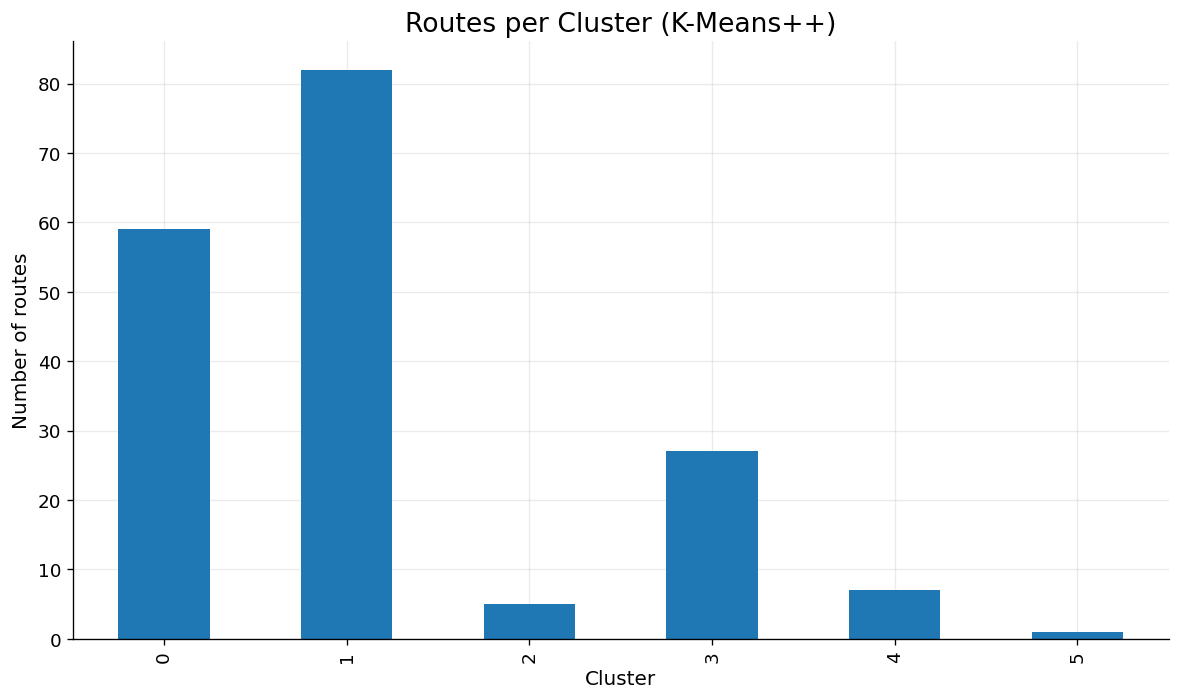

In [25]:
counts = routes_df["cluster_kmeans"].value_counts().sort_index()
plt.figure()
counts.plot(kind="bar")
plt.title("Routes per Cluster (K-Means++)")
plt.xlabel("Cluster"); plt.ylabel("Number of routes")
plt.gca().yaxis.set_major_formatter(FuncFormatter(fmt_thousands))
plt.tight_layout(); plt.show()

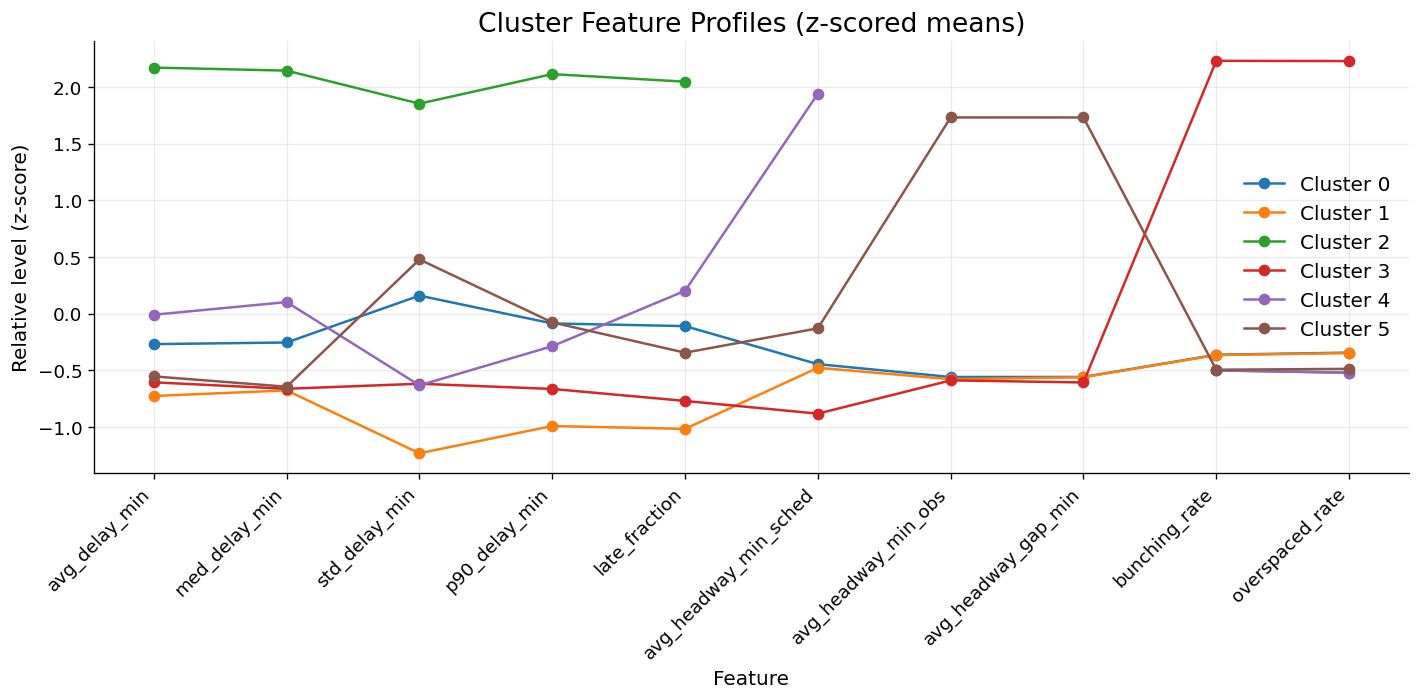

In [26]:
cluster_means = routes_df.groupby("cluster_kmeans")[valid_feats].mean()
cm_norm = (cluster_means - cluster_means.mean()) / cluster_means.std(ddof=0)
plt.figure(figsize=(12, 6))
for i, row in cm_norm.iterrows():
    plt.plot(valid_feats, row.values, marker="o", label=f"Cluster {i}")
plt.title("Cluster Feature Profiles (z-scored means)")
plt.xlabel("Feature"); plt.ylabel("Relative level (z-score)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout(); plt.show()

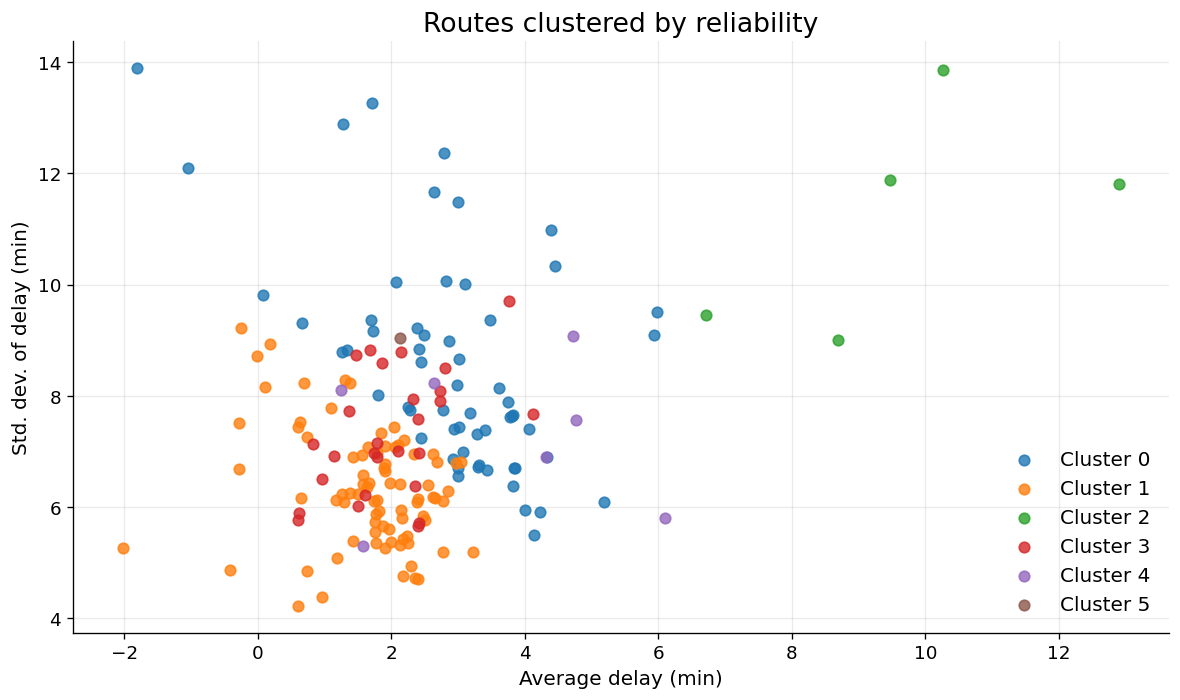

In [27]:
x_col, y_col = "avg_delay_min", "std_delay_min"
if x_col in routes_df.columns and y_col in routes_df.columns:
    plt.figure()
    for lab in sorted(routes_df["cluster_kmeans"].unique()):
        m = routes_df["cluster_kmeans"] == lab
        plt.scatter(routes_df.loc[m, x_col], routes_df.loc[m, y_col], s=40, alpha=0.8, label=f"Cluster {lab}")
    plt.title("Routes clustered by reliability")
    plt.xlabel("Average delay (min)"); plt.ylabel("Std. dev. of delay (min)")
    plt.legend()
    plt.tight_layout(); plt.show()

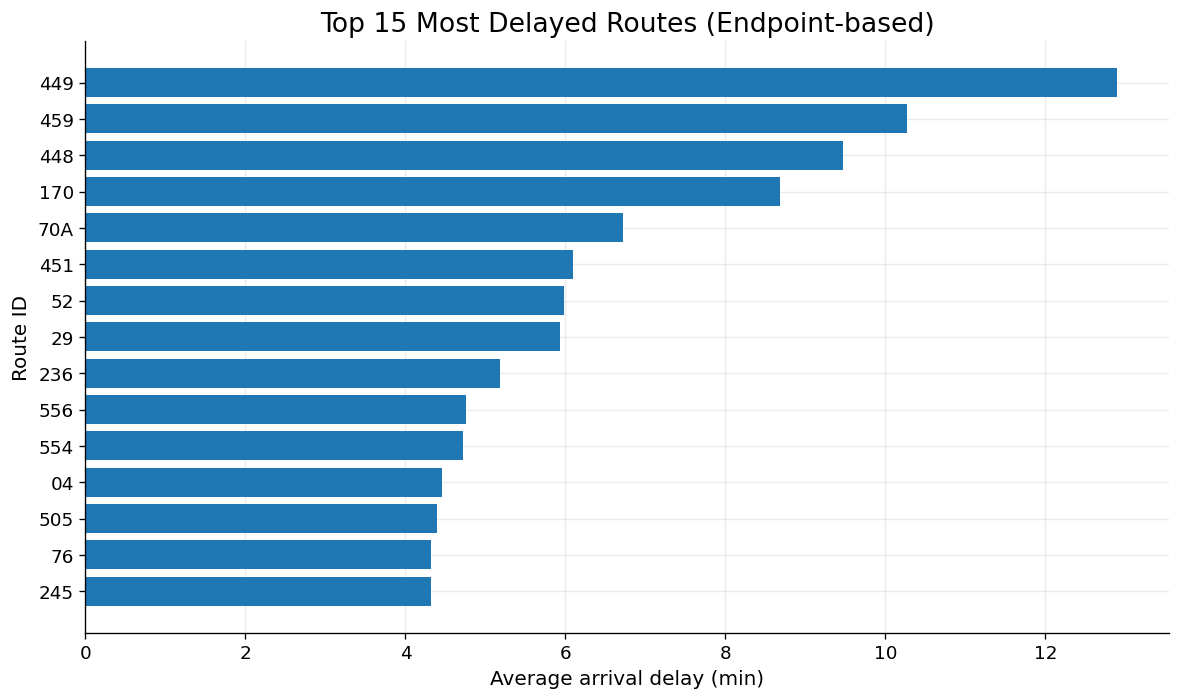

In [28]:
top = routes_df.sort_values("avg_delay_min", ascending=False).head(15)
plt.figure()
plt.barh(top["route_id"].astype(str), top["avg_delay_min"])
plt.gca().invert_yaxis()
plt.title("Top 15 Most Delayed Routes (Endpoint-based)")
plt.xlabel("Average arrival delay (min)"); plt.ylabel("Route ID")
plt.tight_layout(); plt.show()

In [29]:
kpi_cols = ["avg_delay_min", "p90_delay_min", "late_fraction"]
kpi = routes_df.groupby("cluster_kmeans")[kpi_cols].mean().round(2)
print("\nKPI means by cluster:")
display(kpi)


KPI means by cluster:


,avg_delay_min,p90_delay_min,late_fraction
cluster_kmeans,,,
0,2.91,13.31,0.34
1,1.66,8.94,0.22
2,9.61,23.92,0.63
3,1.99,10.52,0.26
4,3.62,12.34,0.39
5,2.13,13.35,0.31
